# AutoML for Images - Retail Drinks - Calling CV model

<img src="https://github.com/retkowsky/AutoMLforImages/blob/main/images/exempledrinks.jpg?raw=true">

In [1]:
#!pip install librosa
#!pip install pymsteams
#!pip install emoji
#!pip install twilio

In [2]:
import azureml.core
from azureml.core import Workspace, Dataset
from azureml.core.webservice import Webservice
import requests
import json
import matplotlib.pyplot as plt 
import cv2
import urllib
import time
from azure.cognitiveservices.speech import AudioDataStream, SpeechConfig, SpeechSynthesizer, SpeechSynthesisOutputFormat
from azure.cognitiveservices.speech.audio import AudioOutputConfig
import azure.cognitiveservices.speech as speechsdk
import librosa, librosa.display, IPython.display as ipd
import pandas as pd
import pymsteams
import smtplib
from email.message import EmailMessage
import emoji

In [3]:
import datetime
dt = datetime.datetime.now()
today = dt.strftime("%Y-%m-%d %H:%M:%S")
print(today)

2021-12-13 11:39:57


In [4]:
import sys
sys.version

'3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) \n[GCC 7.3.0]'

In [7]:
ws = Workspace.from_config()
print("Azure ML workspace:", ws.name, "\nAzure ML resource group:", ws.resource_group)

Azure ML workspace: azuremlvision 
Azure ML resource group: azuremlvision-rg


## Computer vision model to use

In [8]:
service = Webservice(workspace=ws, name='automlcv-drinks')
print(service.scoring_uri)
print(service.swagger_uri)

http://20.93.27.173:80/api/v1/service/automlcv-drinks/score
http://20.93.27.173:80/api/v1/service/automlcv-drinks/swagger.json


In [9]:
primary, secondary = service.get_keys()
# URL for the web service
scoring_uri = service.scoring_uri
# If the service is authenticated, set the key or token
key = primary

## Image to analyze

In [10]:
import urllib
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/drinks1.jpg?raw=true'
#image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/drinks3.jpg?raw=true'

image_file = 'drinks.jpg'
urllib.request.urlretrieve(image_url, filename=image_file)
print("Done: image is available")

Done: image is available


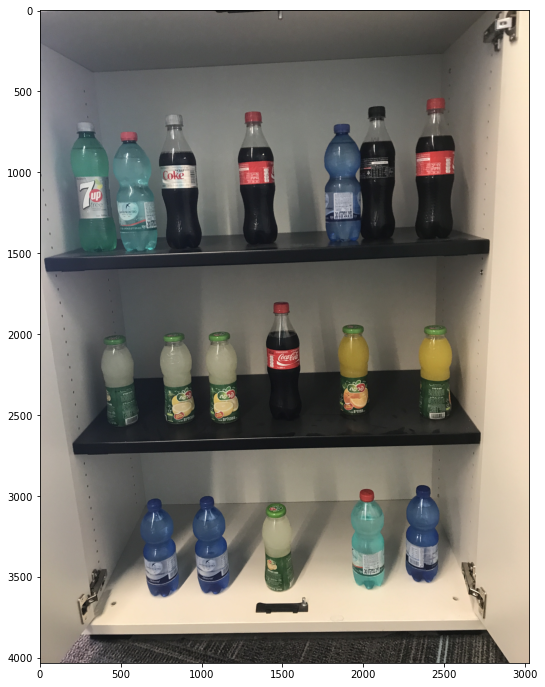

In [11]:
img = cv2.imread(image_file)
h, w, c = img.shape
plt.figure(figsize=(12,12)) 
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

In [12]:
# Load image data
data = open(image_file, 'rb').read()
# Set the content type
headers = {'Content-Type': 'application/octet-stream'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print("Status code=",resp.status_code)
print("Elapsed=", resp.elapsed)
print("Results=", resp.text)

Status code= 200
Elapsed= 0:00:00.883430
Results= {"filename": "/tmp/tmp_6183bcu", "boxes": [{"box": {"topX": 0.7710511016845704, "topY": 0.13204518044419852, "bottomX": 0.8569104766845703, "bottomY": 0.35613295106011084}, "label": "Coca Red", "score": 0.9941055774688721}, {"box": {"topX": 0.404244499206543, "topY": 0.1532930585277908, "bottomX": 0.4827811813354492, "bottomY": 0.3617618983055816}, "label": "Coca Red", "score": 0.9908763766288757}, {"box": {"topX": 0.636288719177246, "topY": 0.7371389879294676, "bottomX": 0.7022129821777344, "bottomY": 0.8853052078447468}, "label": "Flat Water", "score": 0.989890456199646}, {"box": {"topX": 0.6565654754638672, "topY": 0.14581036880808074, "bottomX": 0.7268509674072265, "bottomY": 0.35879694095919323}, "label": "Coca Black", "score": 0.9893507361412048}, {"box": {"topX": 0.4618093109130859, "topY": 0.447433672076542, "bottomX": 0.5300418090820312, "bottomY": 0.6340298250065959}, "label": "Coca Red", "score": 0.9852647185325623}, {"box": 

In [13]:
minscore = 0.65

In [14]:
# draw box and label for each detection 
detections = json.loads(resp.text) # Loading the predictions from the computer vision model
i=1
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    if conf_score >= minscore: #Min probability
        print("\033[1;31;34mObject", i, ":", label, '(', round(conf_score, 2),')')
        i+=1
print("\n\033[1;31;91m >> Total of", i-1, "drinks.")

Object 1 : Coca Red ( 0.99 )
Object 2 : Coca Red ( 0.99 )
Object 3 : Flat Water ( 0.99 )
Object 4 : Coca Black ( 0.99 )
Object 5 : Coca Red ( 0.99 )
Object 6 : Fizzy Water ( 0.98 )
Object 7 : Orange Juice ( 0.97 )
Object 8 : Fizzy Water ( 0.97 )
Object 9 : 7 Up ( 0.96 )
Object 10 : Orange Juice ( 0.96 )
Object 11 : Fizzy Water ( 0.96 )
Object 12 : Grape Fruit ( 0.95 )
Object 13 : Grape Fruit ( 0.95 )
Object 14 : Grape Fruit ( 0.94 )
Object 15 : Grape Fruit ( 0.92 )
Object 16 : Coca Silver ( 0.89 )
Object 17 : Flat Water ( 0.8 )
Object 18 : Fizzy Water ( 0.65 )

 >> Total of 18 drinks.


<Figure size 1080x1080 with 0 Axes>

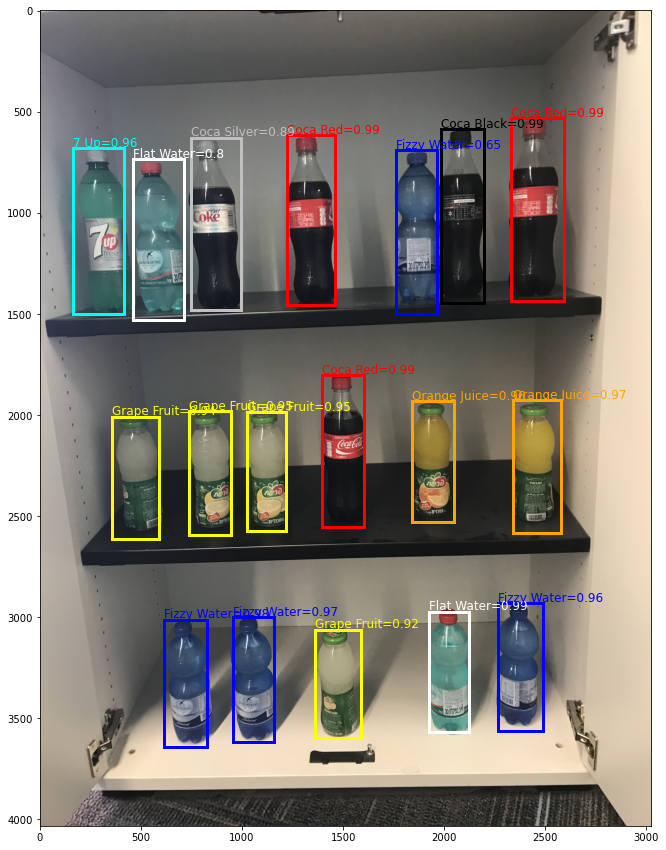

In [22]:
fontsize = 12

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (15,15)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15))

# Display the image
ax.imshow(img_np)

# draw box and label for each detection 
detections = json.loads(resp.text) # Loading the predictions from the computer vision model

for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    if conf_score >= minscore: #Min probability
        ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        
        if label=='7 Up':
            color = 'cyan'
        if label=='Coca Black':
            color = 'black'
        if label=='Coca Silver':
            color = 'silver'
        if label=='Coca Red':
            color = 'red'
        if label=='Fizzy Water':
            color = 'blue'
        if label=='Flat Water':
            color = 'white'
        if label=='Orange Juice':
            color = 'orange'
        if label=='Grape Fruit':
            color = 'yellow'
        
        rect = patches.Rectangle((topleft_x, topleft_y), width, height, linewidth=3, edgecolor=color, facecolor='none')
        textdisp=label+'='+str(round(conf_score, 2))
        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, textdisp, color=color, fontsize=fontsize)  
fig.savefig('CountingDrinks.jpg', dpi=300) #Saving image
        
plt.show()

In [23]:
SUP=0
CB=0
CS=0
CR=0
FIW=0
FLW=0
OJ=0
GF=0
total_drinks=0
resupply=0

# draw box and label for each detection 
detections = json.loads(resp.text) # Loading the predictions from the computer vision model

for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    if conf_score >= minscore:
          
        if label=='7 Up':
            SUP+=1     
        if label=='Coca Black':
            CB+=1
        if label=='Coca Silver':
            CS+=1
        if label=='Coca Red':
            CR+=1
        if label=='Fizzy Water':
            FIW+=1
        if label=='Flat Water':
            FLW+=1
        if label=='Orange Juice':
            OJ+=1
        if label=='Grape Fruit':
            GF+=1
    
total_drinks=SUP+CB+CS+CR+FIW+FLW+OJ+GF
total_capacity=24
resupply=total_capacity-total_drinks
print("Drinks detected:\n")
print("- Number of 7Up =", SUP)
print("- Number of Coca Black =", CB)
print("- Number of Coca Silver =", CS)
print("- Number of Coca Red =", CR)
print("- Number of Fizzy Water =", FIW)
print("- Number of Flat Water =", FLW)
print("- Number of Grape Fruit Juice =", GF)
print("- Number of Orange Juice =", OJ)
print()
print("\033[1;31;34mTotal of detected drinks =", total_drinks, "| Total capacity is =", total_capacity,'drinks.')
print("\033[1;31;31m>> Need to resupply =", resupply, 'drinks.')

Drinks detected:

- Number of 7Up = 1
- Number of Coca Black = 1
- Number of Coca Silver = 1
- Number of Coca Red = 3
- Number of Fizzy Water = 4
- Number of Flat Water = 2
- Number of Grape Fruit Juice = 4
- Number of Orange Juice = 2

Total of detected drinks = 18 | Total capacity is = 24 drinks.
>> Need to resupply = 6 drinks.


## Speech to Text

In [24]:
azureSTT_key = '90874240bf4146ffacf843faed7e7a84'
azureSTT_region = 'eastus'

In [25]:
LanguageToUse = 'EN'

audiofile = 'drinksdetection_' + LanguageToUse + '.wav'
if LanguageToUse == 'FR':
    MSG = 'Le nombre total de boissons détectées est de ' + str(total_drinks) + '. Nous devons réapprovisionner ' + str(resupply) + ' boissons.'
    LANGUAGE = "fr-FR"   
if LanguageToUse == 'EN':
    MSG = "Total number of detected drinks is " + str(total_drinks) + '. We need to resupply ' + str(resupply) + ' drinks.'
    LANGUAGE = "en-EN"

In [26]:
speech_config = SpeechConfig(subscription=azureSTT_key, region=azureSTT_region)
speech_config.speech_synthesis_language = LANGUAGE # Language to use

audio_config = AudioOutputConfig(filename=audiofile)
speech_synthesizer = speechsdk.SpeechSynthesizer(speech_config=speech_config)
synthesizer = SpeechSynthesizer(speech_config=speech_config, audio_config=audio_config,)
synthesizer.speak_text_async(MSG) # Text to Speech using the MSG text

from os.path import getsize
sizefile=getsize(audiofile)

print(f"Size of '{audiofile}' file = {sizefile}")
print("Audio file date: %s" % time.ctime(os.path.getmtime(audiofile)))

samples, sampling_rate = librosa.load(audiofile, sr = None, mono = True, offset = 0.0, duration = None)
duration = len(samples) / sampling_rate
print("Audio file duration =", round(duration, 3), 'seconds')

Size of 'drinksdetection_EN.wav' file = 199248
Audio file date: Mon Dec 13 11:42:01 2021
Audio file duration = 6.225 seconds


In [29]:
from IPython.display import Audio
print("Playing the audio file in", LANGUAGE, ':')
print()
print("\033[1;31;34m", MSG)
Audio(audiofile)

Playing the audio file in en-EN :

 Total number of detected drinks is 18. We need to resupply 6 drinks.


In [30]:
print(MSG)

Total number of detected drinks is 18. We need to resupply 6 drinks.


## Statistics

In [31]:
cvstats=[['Seven Up', SUP], ['Coca Black', CB], ['Coca Silver', CS], 
         ['Coca Red', CR], ['Fizzy Water', FIW], ['Flat Water', FLW],
         ['Grape Fruit Juice', GF], ['Orange Juice', OJ]]

cvstatsdf = pd.DataFrame(cvstats, columns = ['Detected Drinks', 'Number of Drinks'])
cvstatsdf_sorted=cvstatsdf.sort_values(by=['Number of Drinks'], ascending=False)

import seaborn as sns
cm = sns.light_palette("red", as_cmap=True)
cvstatsdf_sorted.style.background_gradient(cmap=cm).set_precision(2)

,Detected Drinks,Number of Drinks
4,Fizzy Water,4
6,Grape Fruit Juice,4
3,Coca Red,3
5,Flat Water,2
7,Orange Juice,2
0,Seven Up,1
1,Coca Black,1
2,Coca Silver,1


In [32]:
LanguageToUse = 'EN'

audiofile = 'drinksdetectiondetails_' + LanguageToUse + '.wav'

if LanguageToUse == 'EN':
    LANGUAGE = "en-EN"
    MSG1 = "Number of 7Up = " + str(SUP)
    MSG2 = ". Number of Coca Black = " + str(CB)
    MSG3 = ". Number of Coca Silver = " + str(CS)
    MSG4 = ". Number of Coca Red  = " + str(CR)
    MSG5 = ". Number of Fizzy Water = " + str(FIW)
    MSG6 = ". Number of Flat Water = " + str(FLW)
    MSG7 = ". Number of Grape Fruit Juice = " + str(GF)
    MSG8 = ". Number of Orange Juice  = " + str(OJ)
    MSGTOTAL = MSG1 + MSG2 + MSG3 + MSG4 + MSG5 + MSG6 + MSG7 + MSG8

speech_config = SpeechConfig(subscription=azureSTT_key, region=azureSTT_region)
speech_config.speech_synthesis_language = LANGUAGE # Language to use

audio_config = AudioOutputConfig(filename=audiofile)
speech_synthesizer = speechsdk.SpeechSynthesizer(speech_config=speech_config)
synthesizer = SpeechSynthesizer(speech_config=speech_config, audio_config=audio_config,)

synthesizer.speak_text_async(MSGTOTAL) # Text to Speech using the MSG text

from os.path import getsize
sizefile=getsize(audiofile)
print(f"Size of '{audiofile}' file = {sizefile}")
print("Audio file date: %s" % time.ctime(os.path.getmtime(audiofile)))

samples, sampling_rate = librosa.load(audiofile, sr = None, mono = True, offset = 0.0, duration = None)
duration = len(samples) / sampling_rate
print("Audio file duration =", round(duration, 3), 'seconds')

Size of 'drinksdetectiondetails_EN.wav' file = 748452
Audio file date: Mon Dec 13 11:42:33 2021
Audio file duration = 23.388 seconds


In [33]:
print("Playing the audio file in", LANGUAGE)
Audio(audiofile)

Playing the audio file in en-EN


In [34]:
print(MSGTOTAL)

Number of 7Up = 1. Number of Coca Black = 1. Number of Coca Silver = 1. Number of Coca Red  = 3. Number of Fizzy Water = 4. Number of Flat Water = 2. Number of Grape Fruit Juice = 4. Number of Orange Juice  = 2


## Statistics

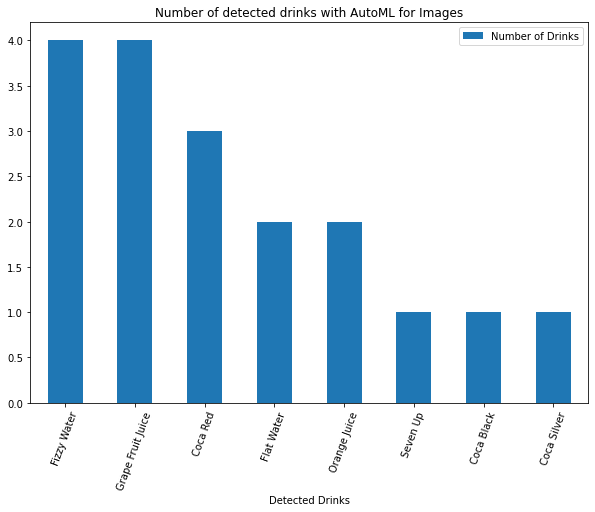

In [35]:
cvstatsdf_sorted.plot(kind='bar', x="Detected Drinks", y="Number of Drinks", 
                      rot=70, title="Number of detected drinks with AutoML for Images", figsize=(10,7))

## Sending results to TEAMS

In [36]:
from datetime import datetime
now = datetime.now()
TeamsMSG1 = '[' + str(now) + '] Warning: ' + MSG
TeamsMSG2 = '[' + str(now) + '] Drinks detected: ' + MSGTOTAL
print('First message to send to Teams:\n\n', TeamsMSG1)

First message to send to Teams:

 [2021-12-13 11:42:39.926224] Warning: Total number of detected drinks is 18. We need to resupply 6 drinks.


In [37]:
print('Second message to send to Teams:\n\n', TeamsMSG2)

Second message to send to Teams:

 [2021-12-13 11:42:39.926224] Drinks detected: Number of 7Up = 1. Number of Coca Black = 1. Number of Coca Silver = 1. Number of Coca Red  = 3. Number of Fizzy Water = 4. Number of Flat Water = 2. Number of Grape Fruit Juice = 4. Number of Orange Juice  = 2


### Sending 1st message to TEAMS

In [38]:
teams="https://microsoft.webhook.office.com/webhookb2/cc71dfbf-6be5-4ff5-b3b2-31fc995339f8@72f988bf-86f1-41af-91ab-2d7cd011db47/IncomingWebhook/ba813ea64f9243d7b47f615e0d2c6f2c/ff4137a8-2d37-4ee7-8675-9876eba469ce"
print("Sending message to TEAMS...")
myTeamsMessage = pymsteams.connectorcard(teams)
myTeamsMessage.text(TeamsMSG1)
myTeamsMessage.send()
print(emoji.emojize(':thumbs_up:'), 'Done.')

Sending message to TEAMS...
👍 Done.


### Sending 2nd message to TEAMS

In [39]:
print("Sending message to TEAMS...")
myTeamsMessage.text(TeamsMSG2)
myTeamsMessage.send()
print(emoji.emojize(':thumbs_up:'), 'Done.')

Sending message to TEAMS...
👍 Done.


## Sending SMS

In [40]:
# Sending the licence plate number by SMS
from twilio.rest import Client

print("Sending SMS...")

# SMS Twilio account details
twilio_account_sid = 'ACb13ecc78dad72e6a31c2b269bae401fe'
twilio_auth_token = '4e9839cb4a8ada798fbf96cdad416bec'
twilio_source_phone_number = '+14708239698'

client = Client(twilio_account_sid, twilio_auth_token)

smstext = TeamsMSG1
print(smstext)

message = client.messages.create(
          body=smstext,
          from_=twilio_source_phone_number,
          to="+33762879986")

print(emoji.emojize(':thumbs_up:'), 'SMS sent!')

Sending SMS...
[2021-12-13 11:42:39.926224] Warning: Total number of detected drinks is 18. We need to resupply 6 drinks.
👍 SMS sent!


## Sending email

In [41]:
# Retrieve email parameters from email_parameters.py
import email_parameters as emailparams
EMAIL_SENDER = emailparams.EMAIL_SENDER
EMAIL_PASSWORD = emailparams.EMAIL_PASSWORD
EMAIL_RECEIVER = emailparams.EMAIL_RECEIVER

In [42]:
import datetime
emaildate = datetime.datetime.today().strftime ('%d-%b-%Y %H:%M:%S')

msg = EmailMessage()

msg['Subject'] = '[Drinks App] ' + MSG + ' ' + str(emaildate)
msg['From'] = EMAIL_SENDER 
msg['To'] = EMAIL_RECEIVER 

msg.set_content(MSG)

attachedfile1 = "CountingDrinks.jpg"
attachedfile2 = audiofile

with open(attachedfile1, 'rb') as pdf:
    msg.add_attachment(pdf.read(), maintype='application', subtype='octet-stream', filename=pdf.name)

with open(attachedfile2, 'rb') as pdf:
    msg.add_attachment(pdf.read(), maintype='application', subtype='octet-stream', filename=pdf.name)
    
with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp:
    print(emaildate, "Sending email...")
    smtp.login(EMAIL_SENDER, EMAIL_PASSWORD) 
    smtp.send_message(msg)
    print(emoji.emojize(':thumbs_up:'), 'Done.')

13-Dec-2021 11:43:27 Sending email...
👍 Done.


> End